<a href="https://colab.research.google.com/github/apoorvapu/data_science/blob/main/HUMAN_vs_AI_art.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [27]:
# 1️⃣ Setup
!pip install timm lightgbm xgboost scikit-learn opencv-python pillow matplotlib seaborn kaggle --quiet


In [28]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Path to your kaggle.json in Google Drive
KAGGLE_JSON = "/content/drive/MyDrive/kaggle.json"  # <-- change if needed

import os
os.makedirs("/root/.kaggle", exist_ok=True)
!cp "{KAGGLE_JSON}" /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json


Mounted at /content/drive


In [29]:
!mkdir -p ./data/art_dataset
!kaggle datasets download -d kausthubkannan/ai-and-human-art-classification -p ./data/art_dataset
!unzip -q -n ./data/art_dataset/ai-and-human-art-classification.zip -d ./data/art_dataset/

Dataset URL: https://www.kaggle.com/datasets/kausthubkannan/ai-and-human-art-classification
License(s): DbCL-1.0
ai-and-human-art-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [30]:
import pathlib, random, time
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image


In [31]:
# Dataset paths
DATA_ROOT = pathlib.Path("./data/art_dataset/ai_art_classification/train")
HUMAN_PATH = DATA_ROOT / "NON_AI_GENERATED"
AI_PATH    = DATA_ROOT / "AI_GENERATED"

assert HUMAN_PATH.exists() and AI_PATH.exists(), "Dataset folders not found!"

from itertools import islice
human_files = list(islice(HUMAN_PATH.glob("*.jpg"), 1000)) # taking only 5000 images
ai_files    = list(islice(AI_PATH.glob("*.jpg"), 1000)) # taking only 5000 images

all_files = human_files + ai_files
labels = [0]*len(human_files) + [1]*len(ai_files)

# Split: 64% train, 16% val, 20% test
train_files, test_files, train_labels, test_labels = train_test_split(
    all_files, labels, test_size=0.2, stratify=labels, random_state=42
)
train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

print(f"Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")


Train: 1280, Val: 320, Test: 400


# Handcrafted Feature Extraction

In [32]:
def extract_features(img_path):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (128,128))

    features = []

    # Color stats
    mean_colors = img_resized.mean(axis=(0,1))
    std_colors  = img_resized.std(axis=(0,1))
    features.extend(mean_colors)
    features.extend(std_colors)

    # Texture entropy
    gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist /= hist.sum()
    entropy = -np.sum(hist*np.log2(hist+1e-7))
    features.append(entropy)

    # Edge density
    edges = cv2.Canny(gray,100,200)
    edge_density = edges.mean()
    features.append(edge_density)

    return np.array(features)

# Extract for all splits
X_train_hand = np.array([extract_features(f) for f in train_files])
X_val_hand   = np.array([extract_features(f) for f in val_files])
X_test_hand  = np.array([extract_features(f) for f in test_files])

# Scale features
scaler = StandardScaler()
X_train_hand = scaler.fit_transform(X_train_hand)
X_val_hand   = scaler.transform(X_val_hand)
X_test_hand  = scaler.transform(X_test_hand)


# Deep CNN Features (EfficientNet-B0)

In [33]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

cnn_model = models.efficientnet_b0(pretrained=True)
cnn_model.classifier = nn.Identity()  # Remove final classifier
cnn_model.eval().cuda()

def extract_cnn_features(file_list):
    feats = []
    with torch.no_grad():
        for f in file_list:
            img = Image.open(f).convert("RGB")
            x = transform(img).unsqueeze(0).cuda()
            feat = cnn_model(x).cpu().numpy().flatten()
            feats.append(feat)
    return np.array(feats)

X_train_cnn = extract_cnn_features(train_files)
X_val_cnn   = extract_cnn_features(val_files)
X_test_cnn  = extract_cnn_features(test_files)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Multi-Modal Ensemble

In [34]:
# Combine handcrafted + CNN
X_train = np.hstack([X_train_hand, X_train_cnn])
X_val   = np.hstack([X_val_hand, X_val_cnn])
X_test  = np.hstack([X_test_hand, X_test_cnn])

# Base classifiers
rf = RandomForestClassifier(n_estimators=200, random_state=42)
xgb_clf = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False)
lgbm_clf = lgb.LGBMClassifier()

for clf in [rf, xgb_clf, lgbm_clf]:
    clf.fit(X_train, train_labels)

# Stacking ensemble
val_preds = np.column_stack([rf.predict_proba(X_val)[:,1],
                             xgb_clf.predict_proba(X_val)[:,1],
                             lgbm_clf.predict_proba(X_val)[:,1]])

stacker = lgb.LGBMClassifier()
stacker.fit(val_preds, val_labels)

# Final test predictions
test_preds = np.column_stack([rf.predict_proba(X_test)[:,1],
                              xgb_clf.predict_proba(X_test)[:,1],
                              lgbm_clf.predict_proba(X_test)[:,1]])
final_preds = stacker.predict(test_preds)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:31:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 640, number of negative: 640
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328440
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 1288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 160, number of negative: 160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


# Evaluation

              precision    recall  f1-score   support

       Human       0.89      0.82      0.85       200
          AI       0.84      0.90      0.86       200

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400



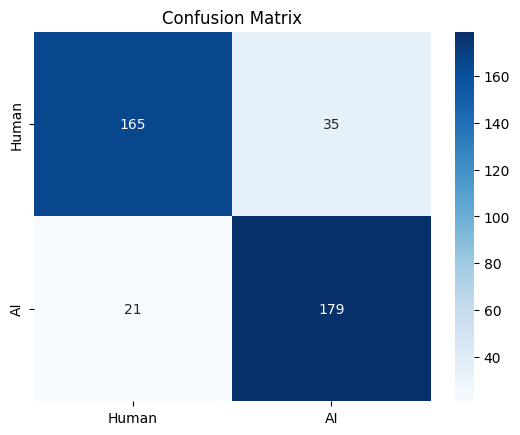

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


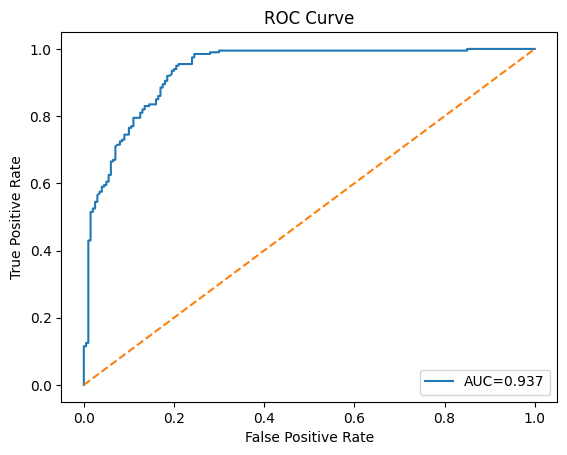

In [35]:
# Classification report
print(classification_report(test_labels, final_preds, target_names=["Human","AI"]))

# Confusion matrix
cm = confusion_matrix(test_labels, final_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Human","AI"], yticklabels=["Human","AI"])
plt.title("Confusion Matrix")
plt.show()

# ROC curve
probs = stacker.predict_proba(test_preds)[:,1]
fpr, tpr, _ = roc_curve(test_labels, probs)
auc = roc_auc_score(test_labels, probs)
plt.plot(fpr,tpr,label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(); plt.show()


# Misclassified Examples

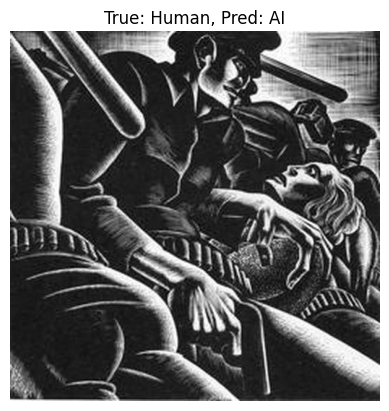

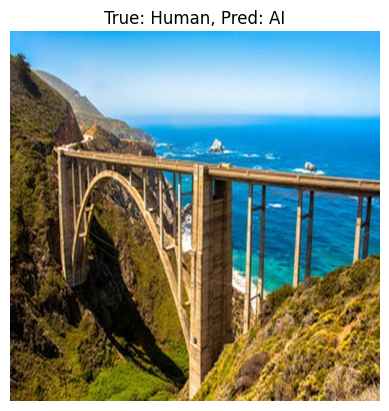

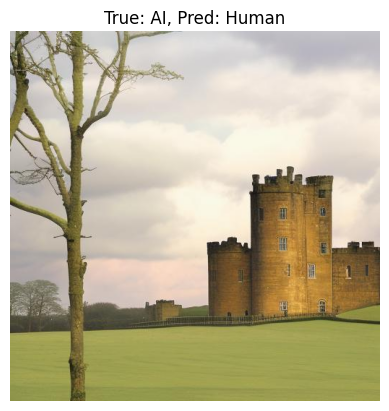

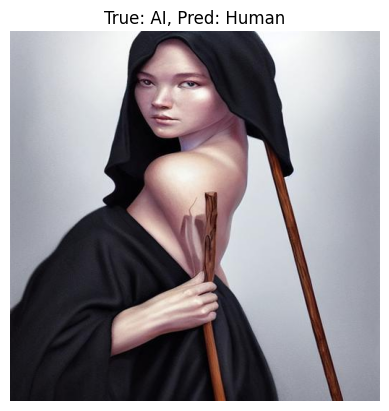

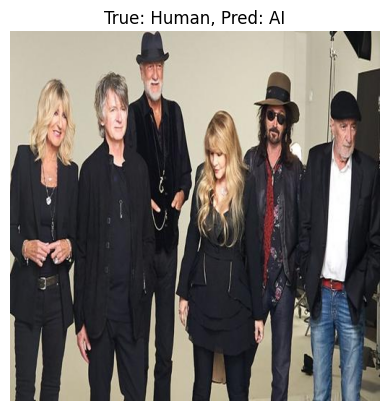

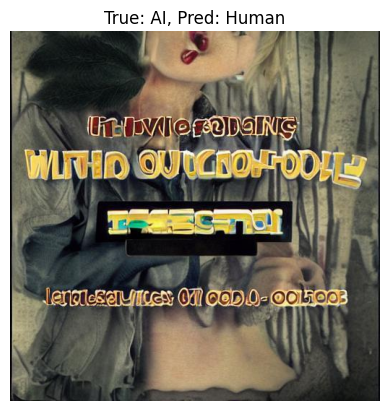

In [36]:
wrong_idx = [i for i,p in enumerate(final_preds) if p!=test_labels[i]]
random.shuffle(wrong_idx)

for i in wrong_idx[:6]:
    img = Image.open(test_files[i])
    plt.imshow(img)
    plt.title(f"True: {['Human','AI'][test_labels[i]]}, Pred: {['Human','AI'][final_preds[i]]}")
    plt.axis('off')
    plt.show()


# Feature Importance (Handcrafted + CNN Ensemble)

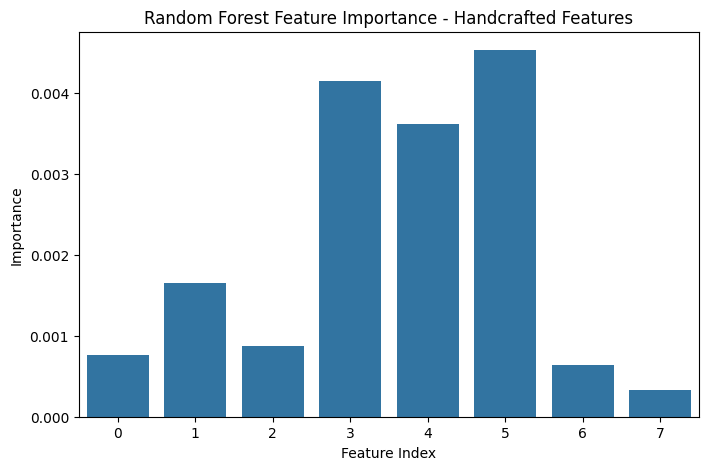

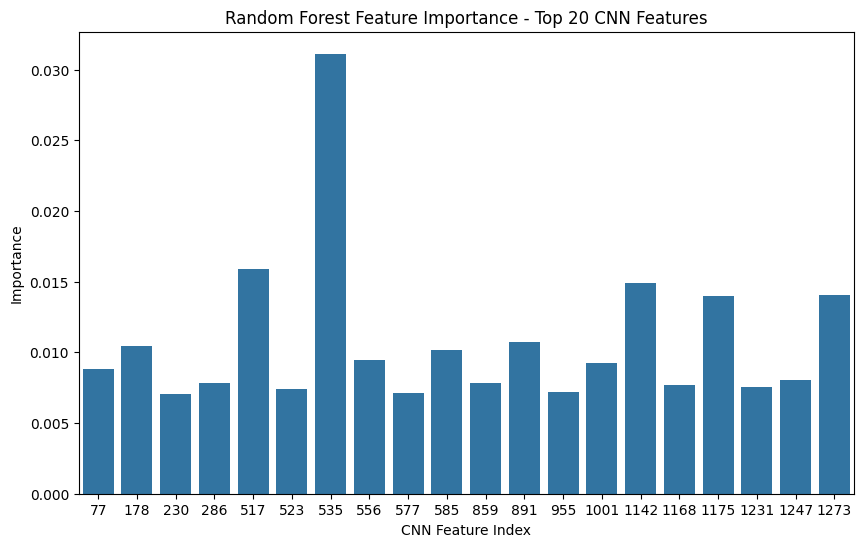

In [37]:
# Feature importance for Random Forest (handcrafted + CNN combined)
importances = rf.feature_importances_

# Split into handcrafted vs CNN features
num_hand = X_train_hand.shape[1]
hand_imp = importances[:num_hand]
cnn_imp  = importances[num_hand:]

# Plot top handcrafted features
plt.figure(figsize=(8,5))
sns.barplot(x=np.arange(len(hand_imp)), y=hand_imp)
plt.title("Random Forest Feature Importance - Handcrafted Features")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

# Plot top CNN features (show top 20)
top_idx = np.argsort(cnn_imp)[-20:]
plt.figure(figsize=(10,6))
sns.barplot(x=top_idx, y=cnn_imp[top_idx])
plt.title("Random Forest Feature Importance - Top 20 CNN Features")
plt.xlabel("CNN Feature Index")
plt.ylabel("Importance")
plt.show()


# UMAP Embedding of Test Set

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


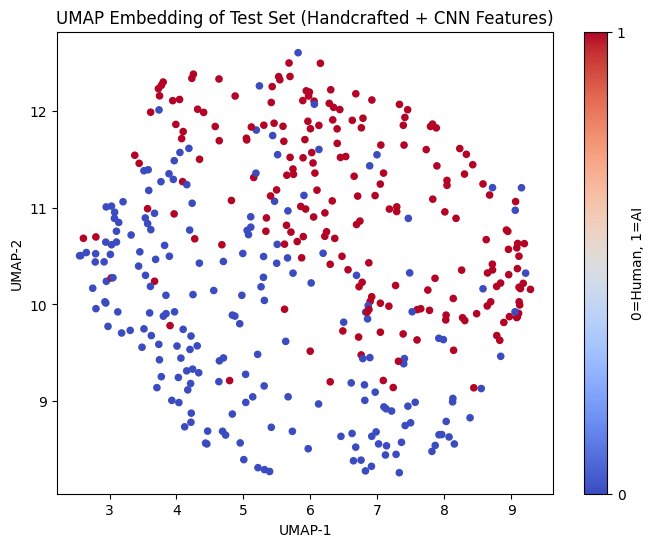

In [38]:
import umap

# Fit UMAP on combined features
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(np.hstack([X_test_hand, X_test_cnn]))

plt.figure(figsize=(8,6))
plt.scatter(embedding[:,0], embedding[:,1], c=test_labels, cmap='coolwarm', s=20)
plt.colorbar(ticks=[0,1], label='0=Human, 1=AI')
plt.title("UMAP Embedding of Test Set (Handcrafted + CNN Features)")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.show()


# Human vs AI Feature Comparison

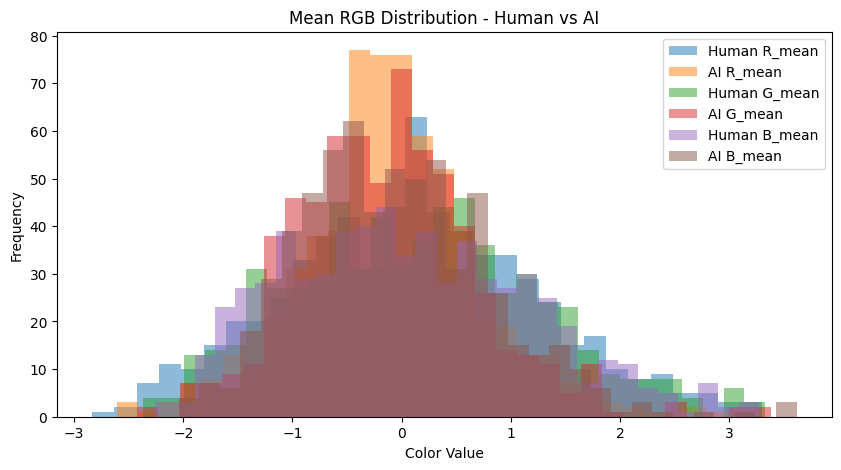

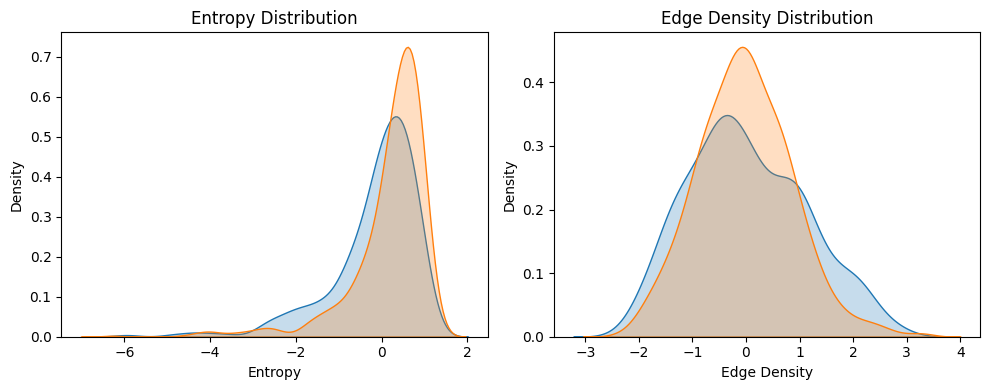

In [39]:
# Compare mean RGB color across Human vs AI images
hand_features_df = pd.DataFrame(X_train_hand, columns=[
    'R_mean','G_mean','B_mean','R_std','G_std','B_std','Entropy','EdgeDensity'
])
hand_features_df['Label'] = train_labels

# Separate Human vs AI
human_feat = hand_features_df[hand_features_df['Label']==0]
ai_feat    = hand_features_df[hand_features_df['Label']==1]

plt.figure(figsize=(10,5))
for i, color in enumerate(['R_mean','G_mean','B_mean']):
    plt.hist(human_feat[color], bins=30, alpha=0.5, label=f'Human {color}')
    plt.hist(ai_feat[color], bins=30, alpha=0.5, label=f'AI {color}')
plt.title("Mean RGB Distribution - Human vs AI")
plt.xlabel("Color Value"); plt.ylabel("Frequency")
plt.legend()
plt.show()

# Compare Entropy and Edge Density
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.kdeplot(human_feat['Entropy'], label='Human', fill=True)
sns.kdeplot(ai_feat['Entropy'], label='AI', fill=True)
plt.title("Entropy Distribution")
plt.xlabel("Entropy")

plt.subplot(1,2,2)
sns.kdeplot(human_feat['EdgeDensity'], label='Human', fill=True)
sns.kdeplot(ai_feat['EdgeDensity'], label='AI', fill=True)
plt.title("Edge Density Distribution")
plt.xlabel("Edge Density")

plt.tight_layout()
plt.show()


In [40]:

# Configuration: adjust these before running heavy experiments
import os, torch
FAST_TRAIN = False   # Set True to favor speed (non-deterministic cudnn.benchmark)
BATCH_SIZE = 64      # adjust based on your GPU memory
NUM_EPOCHS = 10      # default training epochs (increase for final experiments)
LEARNING_RATE = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
    if FAST_TRAIN:
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
    else:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

# num_workers heuristic: cap to 8 to avoid too many processes in Colab
import multiprocessing
NUM_WORKERS = min(8, max(1, multiprocessing.cpu_count() // 2))
PIN_MEMORY = True if torch.cuda.is_available() else False
print(f"NUM_WORKERS={NUM_WORKERS}, PIN_MEMORY={PIN_MEMORY}, BATCH_SIZE={BATCH_SIZE}")


Device: cuda
GPU name: Tesla T4
NUM_WORKERS=1, PIN_MEMORY=True, BATCH_SIZE=64


In [41]:

# Build DataLoaders from train_files, val_files, test_files which should be defined earlier in the notebook.
# Use PathImageDataset to load images from pathlib.Path objects.
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import os, torch

class PathImageDataset(torch.utils.data.Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = list(file_paths)
        self.labels = list(labels)
        self.transform = transform or transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
    def __len__(self):
        return len(self.file_paths)
    def __getitem__(self, idx):
        p = self.file_paths[idx]
        # allow pathlib.Path
        if hasattr(p, 'as_posix'):
            p = p.as_posix()
        img = Image.open(p).convert('RGB')
        img = self.transform(img)
        label = int(self.labels[idx])
        return img, label

# Create datasets (use augmentation for train)
train_dataset = PathImageDataset(train_files, train_labels, transform=transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(), transforms.ToTensor()]))
val_dataset   = PathImageDataset(val_files, val_labels, transform=transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()]))
test_dataset  = PathImageDataset(test_files, test_labels, transform=transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()]))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print("DataLoaders ready. Samples per split:", len(train_dataset), len(val_dataset), len(test_dataset))


DataLoaders ready. Samples per split: 1280 320 400


In [42]:

# Mixed-precision training loop optimized for GPU usage
import torch.cuda.amp as amp
from tqdm.auto import tqdm
import copy, numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score

def train_one_epoch_amp(model, optimizer, loader, device, scaler, scheduler=None):
    model.train()
    losses = []
    all_preds, all_targets = [], []
    for xb, yb in tqdm(loader, leave=False):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        optimizer.zero_grad()
        with amp.autocast(enabled=(device.type=='cuda')):
            out = model(xb)
            loss = torch.nn.functional.cross_entropy(out, yb)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        if scheduler is not None:
            scheduler.step()
        losses.append(loss.item())
        preds = out.detach().argmax(dim=1).cpu().numpy()
        all_preds.append(preds); all_targets.append(yb.detach().cpu().numpy())
    all_preds = np.concatenate(all_preds); all_targets = np.concatenate(all_targets)
    acc = accuracy_score(all_targets, all_preds)
    return np.mean(losses), acc

@torch.no_grad()
def evaluate_amp(model, loader, device):
    model.eval()
    preds, probs, targets = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            out = model(xb)
            probs.append(torch.softmax(out, dim=1)[:, 1].cpu().numpy())
            preds.append(out.argmax(dim=1).cpu().numpy())
            targets.append(yb.cpu().numpy())
    preds   = np.concatenate(preds)
    probs   = np.concatenate(probs)
    targets = np.concatenate(targets)
    # Return in order: ground truth, predictions, probabilities
    return targets, preds, probs

def train_model_amp(model, train_loader, val_loader, device, epochs=5, lr=1e-4, weight_decay=1e-4):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scaler = amp.GradScaler(enabled=(device.type=='cuda'))
    best_state = None
    best_f1 = -1
    history = []

    for epoch in range(1, epochs+1):
        tr_loss, tr_acc = train_one_epoch_amp(model, optimizer, train_loader, device, scaler)

        targets, preds, probs = evaluate_amp(model, val_loader, device)
        p, r, f1, _ = precision_recall_fscore_support(targets, preds, average='binary', zero_division=0)
        try:
            roc = roc_auc_score(targets, probs) if len(np.unique(targets)) == 2 else None
        except Exception:
            roc = None

        history.append({
            'epoch': epoch,
            'val_f1': f1,
            'val_acc': accuracy_score(targets, preds),
            'val_roc': roc
        })
        print(f"Epoch {epoch}: val_f1={f1:.4f} acc={history[-1]['val_acc']:.4f} roc={roc}")

        if f1 > best_f1:
            best_f1 = f1
            best_state = copy.deepcopy(model.state_dict())

    if best_state is not None:
        model.load_state_dict(best_state)

    # Return model first, then history
    return model, history


In [43]:

# Profiling utility: estimate forward throughput (images/sec) for a model
import time
def profile_model(model, loader, device, n_batches=10):
    model = model.to(device).eval()
    times = []
    it = iter(loader)
    # warmup
    for _ in range(3):
        try:
            xb, yb = next(it)
        except StopIteration:
            it = iter(loader); xb, yb = next(it)
        xb = xb.to(device, non_blocking=True)
        _ = model(xb)
    # measure
    it = iter(loader)
    for i in range(n_batches):
        try:
            xb, yb = next(it)
        except StopIteration:
            it = iter(loader); xb, yb = next(it)
        xb = xb.to(device, non_blocking=True)
        t0 = time.time()
        _ = model(xb)
        if device.type=='cuda':
            torch.cuda.synchronize()
        t1 = time.time()
        times.append(t1-t0)
    avg = sum(times)/len(times)
    print(f"Avg forward time per batch: {avg:.4f}s ({BATCH_SIZE} images) -> {BATCH_SIZE/avg:.1f} images/s)")
    return avg


In [44]:
# ===== ResNet50 =====
from torchvision.models import resnet50

resnet = resnet50(weights='IMAGENET1K_V2')
resnet.fc = nn.Linear(resnet.fc.in_features, 2)  # binary classification
resnet.to(device)

best_model_resnet, history_resnet = train_model_amp(
    resnet, train_loader, val_loader, device, epochs=10, lr=1e-4
)

# ===== Vision Transformer =====
from torchvision.models import vit_b_16

vit = vit_b_16(weights='IMAGENET1K_V1')
vit.heads.head = nn.Linear(vit.heads.head.in_features, 2)
vit.to(device)

best_model_vit, history_vit = train_model_amp(
    vit, train_loader, val_loader, device, epochs=10, lr=1e-4
)


/tmp/ipython-input-2484374486.py:50: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler(enabled=(device.type=='cuda'))


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2484374486.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(device.type=='cuda')):


Epoch 1: val_f1=0.8722 acc=0.8562 roc=0.9613281250000001


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2484374486.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(device.type=='cuda')):


Epoch 2: val_f1=0.8991 acc=0.8906 roc=0.9726953125


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2484374486.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(device.type=='cuda')):


Epoch 3: val_f1=0.9128 acc=0.9062 roc=0.9693359375000001


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2484374486.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(device.type=='cuda')):


Epoch 4: val_f1=0.9186 acc=0.9125 roc=0.9704296875


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2484374486.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(device.type=='cuda')):


Epoch 5: val_f1=0.9305 acc=0.9281 roc=0.9748046875


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2484374486.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(device.type=='cuda')):


Epoch 6: val_f1=0.9123 acc=0.9062 roc=0.9662109375


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2484374486.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(device.type=='cuda')):


Epoch 7: val_f1=0.9134 acc=0.9094 roc=0.9731640625


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2484374486.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(device.type=='cuda')):


Epoch 8: val_f1=0.9167 acc=0.9125 roc=0.9735546875000001


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2484374486.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(device.type=='cuda')):


Epoch 9: val_f1=0.9208 acc=0.9156 roc=0.9799609375


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2484374486.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(device.type=='cuda')):


Epoch 10: val_f1=0.9176 acc=0.9125 roc=0.9711328125


/tmp/ipython-input-2484374486.py:50: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler(enabled=(device.type=='cuda'))


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2484374486.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(device.type=='cuda')):


Epoch 1: val_f1=0.9034 acc=0.9031 roc=0.9648828125


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2484374486.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(device.type=='cuda')):


Epoch 2: val_f1=0.8634 acc=0.8438 roc=0.9655859375


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2484374486.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(device.type=='cuda')):


Epoch 3: val_f1=0.9152 acc=0.9125 roc=0.9712109375


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2484374486.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(device.type=='cuda')):


Epoch 4: val_f1=0.9123 acc=0.9062 roc=0.9694921874999999


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2484374486.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(device.type=='cuda')):


Epoch 5: val_f1=0.8957 acc=0.8938 roc=0.96078125


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2484374486.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(device.type=='cuda')):


Epoch 6: val_f1=0.9068 acc=0.9062 roc=0.9670703125


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2484374486.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(device.type=='cuda')):


Epoch 7: val_f1=0.8793 acc=0.8688 roc=0.9475390625


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2484374486.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(device.type=='cuda')):


Epoch 8: val_f1=0.9070 acc=0.9000 roc=0.9697265625


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2484374486.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(device.type=='cuda')):


Epoch 9: val_f1=0.8456 acc=0.8562 roc=0.9573828125


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2484374486.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=(device.type=='cuda')):


Epoch 10: val_f1=0.8985 acc=0.8969 roc=0.9647265625


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eebc79663e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eebc79663e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

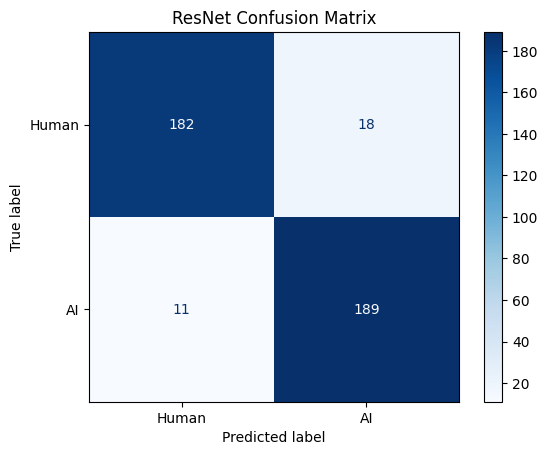

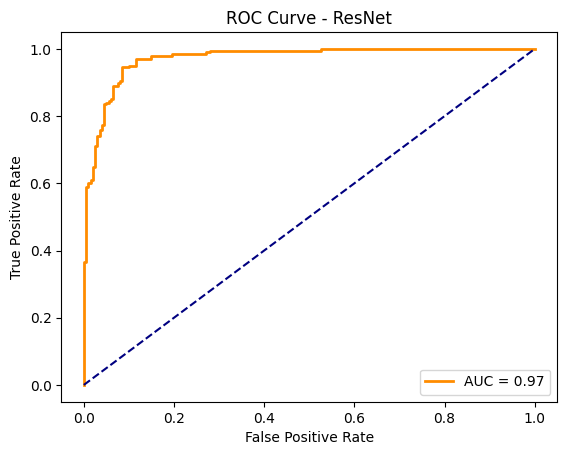

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, f1_score

# ===== ResNet =====
y_true_res, y_pred_res, y_prob_res = evaluate_amp(best_model_resnet, test_loader, device)
f1_res = f1_score(y_true_res, y_pred_res)

cm_res = confusion_matrix(y_true_res, y_pred_res, labels=[0,1])
disp_res = ConfusionMatrixDisplay(confusion_matrix=cm_res, display_labels=['Human','AI'])
disp_res.plot(cmap="Blues")
plt.title("ResNet Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_true_res, y_prob_res)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - ResNet")
plt.legend(loc="lower right")
plt.show()


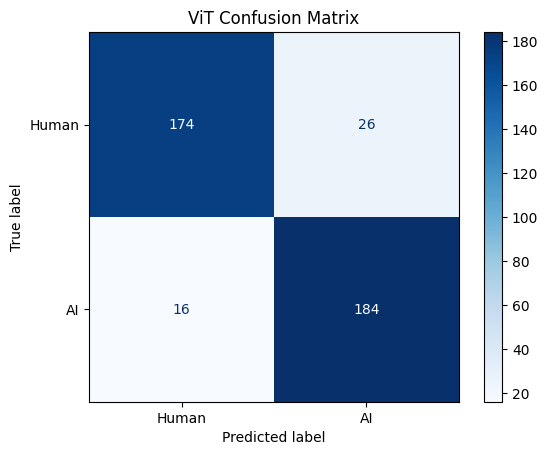

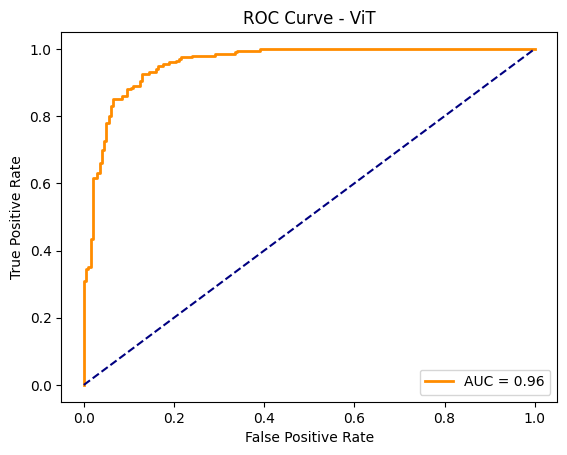

In [46]:
# ===== Vision Transformer (ViT) =====
y_true_vit, y_pred_vit, y_prob_vit = evaluate_amp(best_model_vit, test_loader, device)
f1_vit = f1_score(y_true_vit, y_pred_vit)

# Confusion Matrix
cm_vit = confusion_matrix(y_true_vit, y_pred_vit, labels=[0,1])
disp_vit = ConfusionMatrixDisplay(confusion_matrix=cm_vit, display_labels=['Human','AI'])
disp_vit.plot(cmap="Blues")
plt.title("ViT Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true_vit, y_prob_vit)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - ViT")
plt.legend(loc="lower right")
plt.show()


In [47]:

from sklearn.metrics import accuracy_score, roc_auc_score

# ResNet metrics
acc_res = accuracy_score(y_true_res, y_pred_res)
roc_res = roc_auc_score(y_true_res, y_prob_res)

# ViT metrics
acc_vit = accuracy_score(y_true_vit, y_pred_vit)
roc_vit = roc_auc_score(y_true_vit, y_prob_vit)


# Combine into results DataFrame
results_df = pd.DataFrame([
    {"Model": "ResNet50", "F1": f1_res, "Accuracy": acc_res, "ROC-AUC": roc_res},
    {"Model": "ViT-B16", "F1": f1_vit, "Accuracy": acc_vit, "ROC-AUC": roc_vit},
])

display(results_df)



,Model,F1,Accuracy,ROC-AUC
0,ResNet50,0.928747,0.9275,0.9728
1,ViT-B16,0.897561,0.8950,0.9585


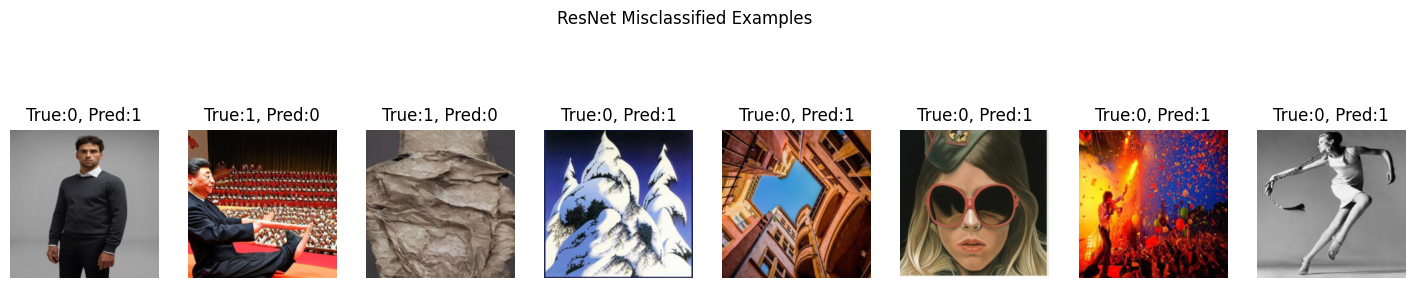

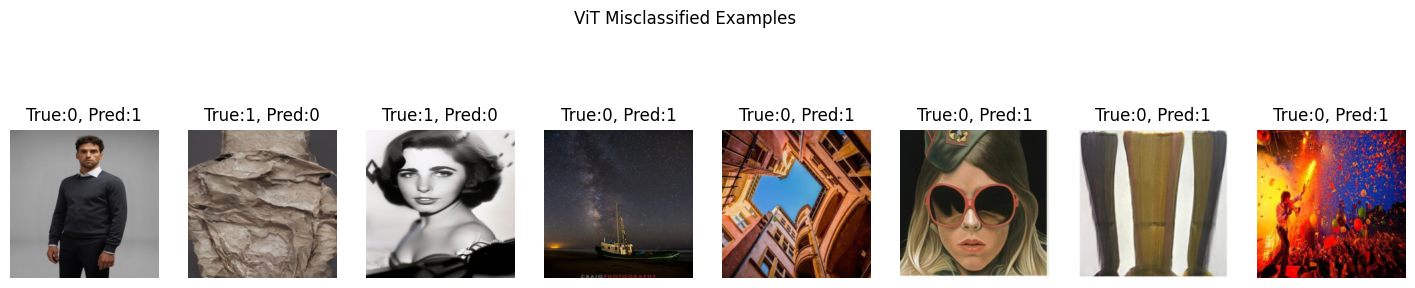

In [48]:
def show_misclassified(model, loader, name, n=8):
    model.eval()
    misclassified = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(1)
            for img, lab, pred in zip(imgs, labels, preds):
                if lab != pred:
                    misclassified.append((img.cpu(), lab.item(), pred.item()))
                if len(misclassified) >= n:
                    break
            if len(misclassified) >= n:
                break

    fig, axes = plt.subplots(1, n, figsize=(18, 4))
    for ax, (img, lab, pred) in zip(axes, misclassified):
        ax.imshow(img.permute(1,2,0).numpy())
        ax.set_title(f"True:{lab}, Pred:{pred}")
        ax.axis("off")
    plt.suptitle(f"{name} Misclassified Examples")
    plt.show()

show_misclassified(best_model_resnet, test_loader, "ResNet")
show_misclassified(best_model_vit, test_loader, "ViT")


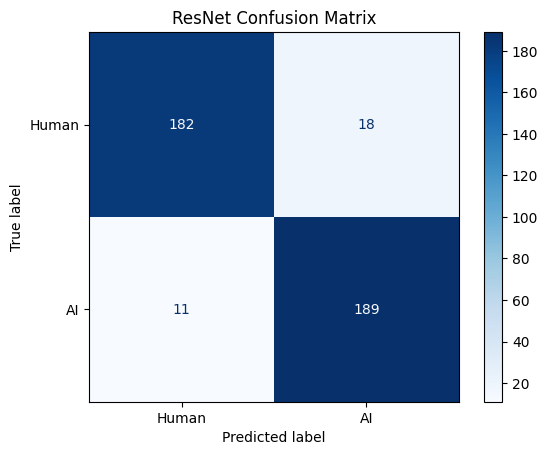

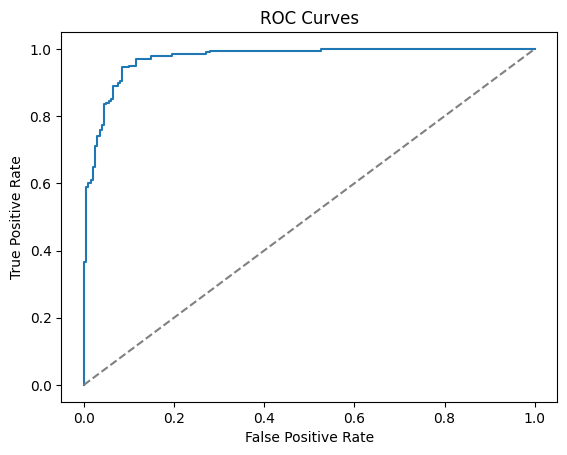

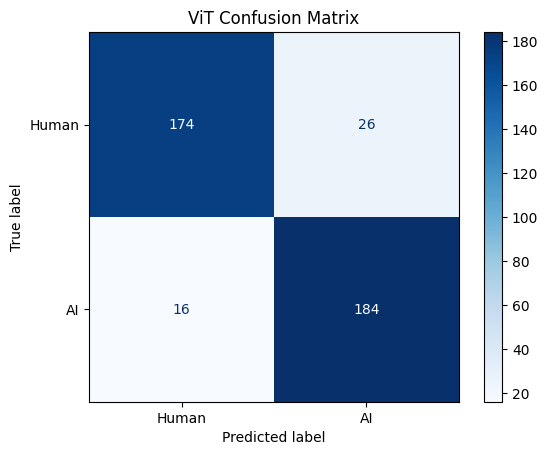

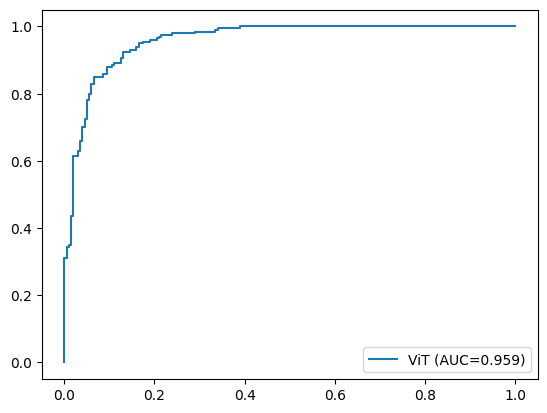

,Model,F1,Accuracy,ROC-AUC
0,ResNet50,0.928747,0.9275,0.9728
1,ViT-B16,0.897561,0.8950,0.9585


Saved results to model_comparison_results.csv


In [49]:

# ===== Consolidated Evaluation: ResNet, ViT =====
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Evaluate ResNet
y_true_res, y_pred_res, y_prob_res = evaluate_amp(best_model_resnet, test_loader, device)
f1_res = f1_score(y_true_res, y_pred_res)
acc_res = accuracy_score(y_true_res, y_pred_res)
roc_res = roc_auc_score(y_true_res, y_prob_res)

cm_res = confusion_matrix(y_true_res, y_pred_res, labels=[0,1])
disp_res = ConfusionMatrixDisplay(confusion_matrix=cm_res, display_labels=['Human','AI'])
disp_res.plot(cmap='Blues')
plt.title('ResNet Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(y_true_res, y_prob_res)
plt.figure()
plt.plot(fpr, tpr, label=f'ResNet (AUC={roc_res:.3f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')

# Evaluate ViT
y_true_vit, y_pred_vit, y_prob_vit = evaluate_amp(best_model_vit, test_loader, device)
f1_vit = f1_score(y_true_vit, y_pred_vit)
acc_vit = accuracy_score(y_true_vit, y_pred_vit)
roc_vit = roc_auc_score(y_true_vit, y_prob_vit)

cm_vit = confusion_matrix(y_true_vit, y_pred_vit, labels=[0,1])
disp_vit = ConfusionMatrixDisplay(confusion_matrix=cm_vit, display_labels=['Human','AI'])
disp_vit.plot(cmap='Blues')
plt.title('ViT Confusion Matrix')
plt.show()

fpr_v, tpr_v, _ = roc_curve(y_true_vit, y_prob_vit)
plt.plot(fpr_v, tpr_v, label=f'ViT (AUC={roc_vit:.3f})')

plt.legend(); plt.show()

# Results table
import pandas as pd
results_df = pd.DataFrame([
    {"Model": "ResNet50", "F1": f1_res, "Accuracy": acc_res, "ROC-AUC": roc_res},
    {"Model": "ViT-B16", "F1": f1_vit, "Accuracy": acc_vit, "ROC-AUC": roc_vit},
])
display(results_df)
# Save results
results_df.to_csv('model_comparison_results.csv', index=False)
print('Saved results to model_comparison_results.csv')
